Imbalanced dataset and hard times with multi-class classification made me switch for now to binary classification. If performance on binary is acceptable, additional classes will be added to the model making it multi-class classification.

In [1]:
# imports
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TensorFlow version: 2.10.0
Keras version: 2.10.0


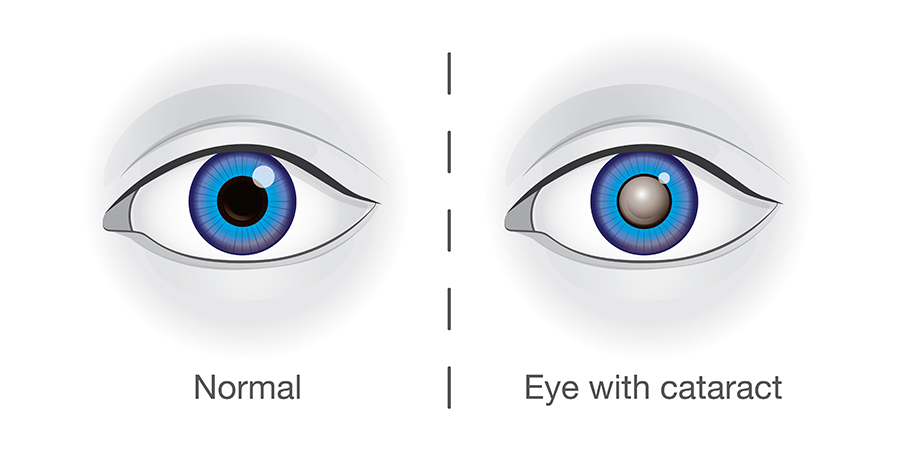

# Binary classification: `Normal` vs `Cataract`

In [2]:
# load dataset csv
df_eye = pd.read_csv('./data/df_eye.csv')
df_eye.head()

,Unnamed: 0,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


#### Only 269 cataract images available (or more - see next cells)

In [3]:
df_eye[df_eye.labels=="['C']"]
# extract only normal and cataract images
df_eye_binary = df_eye[df_eye['labels'].apply(lambda label: label in ["['C']", "['N']"])][['target', 'filename']].copy(deep=True)
df_eye_binary['is_cataract'] = 0
df_eye_binary[df_eye_binary.target == '[0, 0, 0, 1, 0, 0, 0, 0]']['is_cataract'] = 1

C:\Users\kuba2\AppData\Local\Temp\ipykernel_1252\1613819505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye_binary[df_eye_binary.target == '[0, 0, 0, 1, 0, 0, 0, 0]']['is_cataract'] = 1


In [4]:
filtered_df = pd.DataFrame(df_eye[['ID', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'filename']])
# filtered_df = filtered_df.drop_duplicates() # 3183 pairs of eyes
filtered_df['is_cataract'] = 0
filtered_df

,ID,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filename,is_cataract
0,0,0_left.jpg,0_right.jpg,cataract,normal fundus,0_right.jpg,0
1,1,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1_right.jpg,0
2,2,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,2_right.jpg,0
3,4,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,4_right.jpg,0
4,5,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,5_right.jpg,0
...,...,...,...,...,...,...,...
6158,4686,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,4686_left.jpg,0
6159,4688,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,4688_left.jpg,0
6160,4689,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,4689_left.jpg,0
6161,4690,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,4690_left.jpg,0


In [5]:
filtered_df['Left-Diagnostic Keywords'].str.contains('cataract') & filtered_df['filename'].str.contains('left')

0       False
1       False
2       False
3       False
4       False
        ...  
6158    False
6159    False
6160    False
6161    False
6162    False
Length: 6163, dtype: bool

In [6]:
filtered_df[filtered_df['Left-Diagnostic Keywords'].str.contains('cataract') & filtered_df['filename'].str.contains('left')].drop_duplicates()

,ID,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filename,is_cataract
3079,0,0_left.jpg,0_right.jpg,cataract,normal fundus,0_left.jpg,0
3144,81,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,81_left.jpg,0
3163,103,103_left.jpg,103_right.jpg,cataract,normal fundus,103_left.jpg,0
3175,119,119_left.jpg,119_right.jpg,cataract,drusen,119_left.jpg,0
3285,254,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane,254_left.jpg,0
...,...,...,...,...,...,...,...
4516,2240,2240_left.jpg,2240_right.jpg,cataract,cataract,2240_left.jpg,0
4517,2242,2242_left.jpg,2242_right.jpg,cataract,cataract,2242_left.jpg,0
4518,2243,2243_left.jpg,2243_right.jpg,cataract,cataract,2243_left.jpg,0
4519,2246,2246_left.jpg,2246_right.jpg,cataract,cataract,2246_left.jpg,0


#### Some images has more labels than one, it might have `diabetes` and `cataract` but in dataset CSV only one label is marked so some refactoring must be applied.
UPDATE: Never mind, difference about 6 images, so it doesn't make sense to refactor each class for a couple of images 

In [7]:
df_eye[df_eye['Left-Diagnostic Keywords'].str.contains('cataract')].shape

(284, 20)

In [8]:
# The path to store trained models
models_dir = r'./models/' 
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where is original dataset
original_dataset_dir = r'./data/preprocessed_images/'

# The directory where we will store our smaller dataset
base_dir = r'./dataset256_binary/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

split_dir = base_dir + r'split256/'
if not os.path.exists(split_dir):
    os.mkdir(split_dir)

# Prepare directories for the class separation
normal_dir = os.path.join(split_dir, r'normal256')
if not os.path.exists(normal_dir):
    os.mkdir(normal_dir)

cataract_dir = os.path.join(split_dir, r'cataract256')
if not os.path.exists(cataract_dir):
    os.mkdir(cataract_dir)

In [9]:
class DataClass():
    def __init__(self, _name: str, _filenames: [str], _target: [int], _abbreviation: str, _directory: str):
        self.name = _name
        self.filenames = _filenames
        self.target = _target
        self.abbreviation  = _abbreviation
        self.directory = _directory
        
    def __str__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"
    
    def __repr__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"

# THAT'S WRONG! THIS LABEL IS ATTACHED TO EACH PATIENT NOT TO EACH EYE!
# UPDATE: it's correct, labels are correctly assigned even though each label columns are 
# attached to each patient
normal_filenames = df_eye[df_eye.labels == "['N']"].filename.values
cataract_filenames = df_eye[df_eye.labels == "['C']"].filename.values

normal_class = DataClass('normal', normal_filenames, [1, 0, 0, 0, 0, 0, 0, 0], 'N', normal_dir)
cataract_class = DataClass('cataract', cataract_filenames, [0, 0, 0, 1, 0, 0, 0, 0], 'C', cataract_dir)

data_classes = [
    normal_class, 
    cataract_class, 
]

## Undersampling

### Copy images so each class has equal size

In [12]:
from random import sample

num_of_imgs = len(cataract_class.filenames)

# Copy files to each class dir
for data_class in data_classes:
    class_dir = data_class.directory
    if os.path.exists(class_dir) and not os.path.isfile(class_dir):
        # Check if the directory is empty
        if not os.listdir(class_dir):
            # copy files
            data_class.filenames = sample([*data_class.filenames],num_of_imgs)
            for fname in data_class.filenames:
                src = os.path.join(original_dataset_dir, fname)
                img = cv2.imread(src)
                # resize img to 256x256
                resized_img = cv2.resize(img, (256, 256))
                # save scaled img
                dst = data_class.directory + "/" + fname
                cv2.imwrite(dst, resized_img)
                # shutil.copyfile(src, dst)
    # validate if number of each class in dataframe and destination directory is the same
    # assert(num_of_imgs == len(os.listdir(class_dir)), "wrong")

# Split data

In [13]:
train_dir = r'./dataset256_binary/train/'
validation_dir = r'./dataset256_binary/validation/'
test_dir = r'./dataset256_binary/test/'

img_rows = 256
img_cols = 256

In [14]:
from sklearn.model_selection import train_test_split

# prepare data sets
def prepare_data(data_class: DataClass, train_size: float, validation_test_ratio:float, img_count=-1):
    # validation_test_ratio -> how much of `data - train_data` goes to validation
    # 
    # for instance, we've given: train_size, validation_test_ratio
    # then
    # train_size = data * train_size
    # validation_size = ( 1 - train_size) * validation_test_ratio
    # test_size = ( 1 - train_size) * (1 - validation_test_ratio)
    # ---
    
    # check if directories are created
    class_train_dir = os.path.join(train_dir, data_class.name)
    if not os.path.exists(class_train_dir):
        os.makedirs(class_train_dir)
    print(class_train_dir)
    
    class_validation_dir = os.path.join(validation_dir, data_class.name)
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

    class_test_dir = os.path.join(test_dir, data_class.name)
    if not os.path.exists(class_test_dir):
        os.makedirs(class_test_dir)
    
    # split class filenames into three separate bins in line with split ratio
    if img_count == -1:
        class_filenames = data_class.filenames
    else:
        assert(img_count > 0 and img_count < data_class.filenames)
        class_filenames = data_class.filenames[:img_count]
    train_filenames, test_valid_filenames = train_test_split(class_filenames, test_size=1.0-train_size)
    # divide images into test and validation sets
    validation_filenames, test_filenames = train_test_split(test_valid_filenames, test_size=1-validation_test_ratio)
    
    for key, destination_dir, filenames in [('train', class_train_dir, train_filenames), ('test', class_test_dir, test_filenames), ('validation', class_validation_dir, validation_filenames)]:
        if os.path.exists(destination_dir) and not os.path.isfile(destination_dir):
            # Checking if the directory is empty or not
            if not os.listdir(destination_dir):
                # copy files
                for filename in filenames:
                    src = os.path.join(split_dir + f"{data_class.name}256/{filename}")
                    dst = os.path.join(destination_dir, filename)
                    shutil.copyfile(src, dst)
        # validate if number of each class in dataframe and destination directory is the same
        assert(len(filenames) == len(os.listdir(destination_dir)))

In [ ]:
for data_class in data_classes:
    prepare_data(data_class, train_size=0.7, validation_test_ratio=0.7)

### Pie chart 

In [16]:
classes = []
num_of_imgs_list = []

# remove 'other' class
for data_class in [normal_class, cataract_class]:
    classes.append(data_class.name)
    num_of_imgs_list.append(num_of_imgs)

print(classes)
print(num_of_imgs_list)

['normal', 'cataract']
[269, 269]


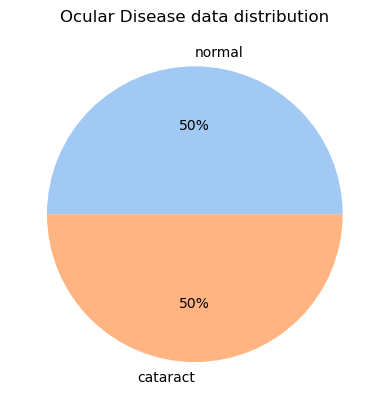

In [17]:
colors = sns.color_palette('pastel')[0:len(classes)]

plt.pie(num_of_imgs_list, labels = classes, colors = colors, autopct='%.0f%%')
plt.title('Ocular Disease data distribution')
plt.show()

## Create image generators

In [19]:
# with augmentation
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # shear_range=0.2,
    # zoom_range=0.05
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1)
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=15,
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=15,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=15,
    class_mode='binary')

Found 376 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


## Create model

In [172]:
# testing
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_rows, img_cols, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [173]:
history1 = model1.fit(
    train_generator, 
    batch_size=37, 
    epochs=10, 
    validation_data=validation_generator
)

Epoch 1/10
26/26 [==============================] - 8s 298ms/step - loss: 0.8174 - accuracy: 0.5133 - val_loss: 0.9452 - val_accuracy: 0.4911
Epoch 2/10
26/26 [==============================] - 5s 206ms/step - loss: 0.6977 - accuracy: 0.5718 - val_loss: 0.6323 - val_accuracy: 0.6429
Epoch 3/10
26/26 [==============================] - 5s 205ms/step - loss: 0.6568 - accuracy: 0.5718 - val_loss: 0.6116 - val_accuracy: 0.6875
Epoch 4/10
26/26 [==============================] - 5s 204ms/step - loss: 0.6669 - accuracy: 0.5745 - val_loss: 0.6250 - val_accuracy: 0.6786
Epoch 5/10
26/26 [==============================] - 6s 213ms/step - loss: 0.6579 - accuracy: 0.6064 - val_loss: 0.6765 - val_accuracy: 0.6161
Epoch 6/10
26/26 [==============================] - 6s 211ms/step - loss: 0.6628 - accuracy: 0.5771 - val_loss: 0.6024 - val_accuracy: 0.6875
Epoch 7/10
26/26 [==============================] - 6s 211ms/step - loss: 0.6416 - accuracy: 0.6223 - val_loss: 0.5957 - val_accuracy: 0.6607
Epoch 

In [27]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

def PlotAccuracyComparison(acc, val_acc, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

<Figure size 640x480 with 0 Axes>

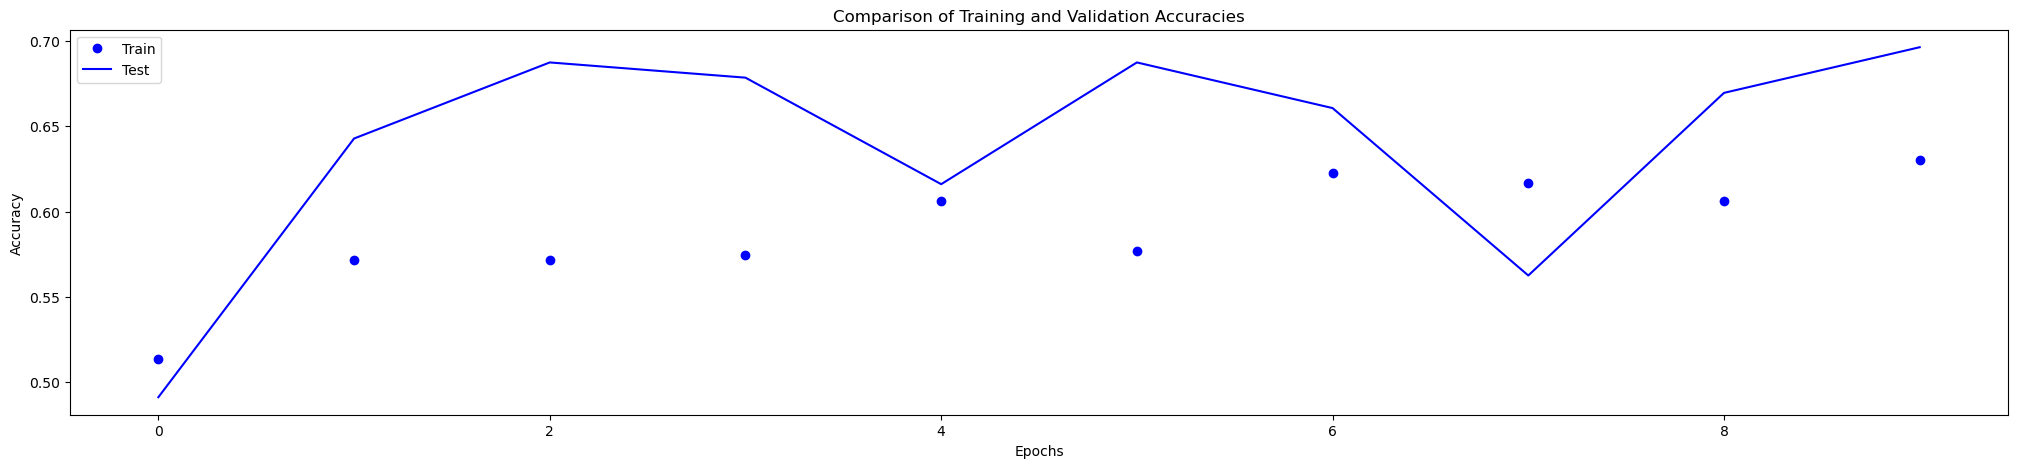

<Figure size 640x480 with 0 Axes>

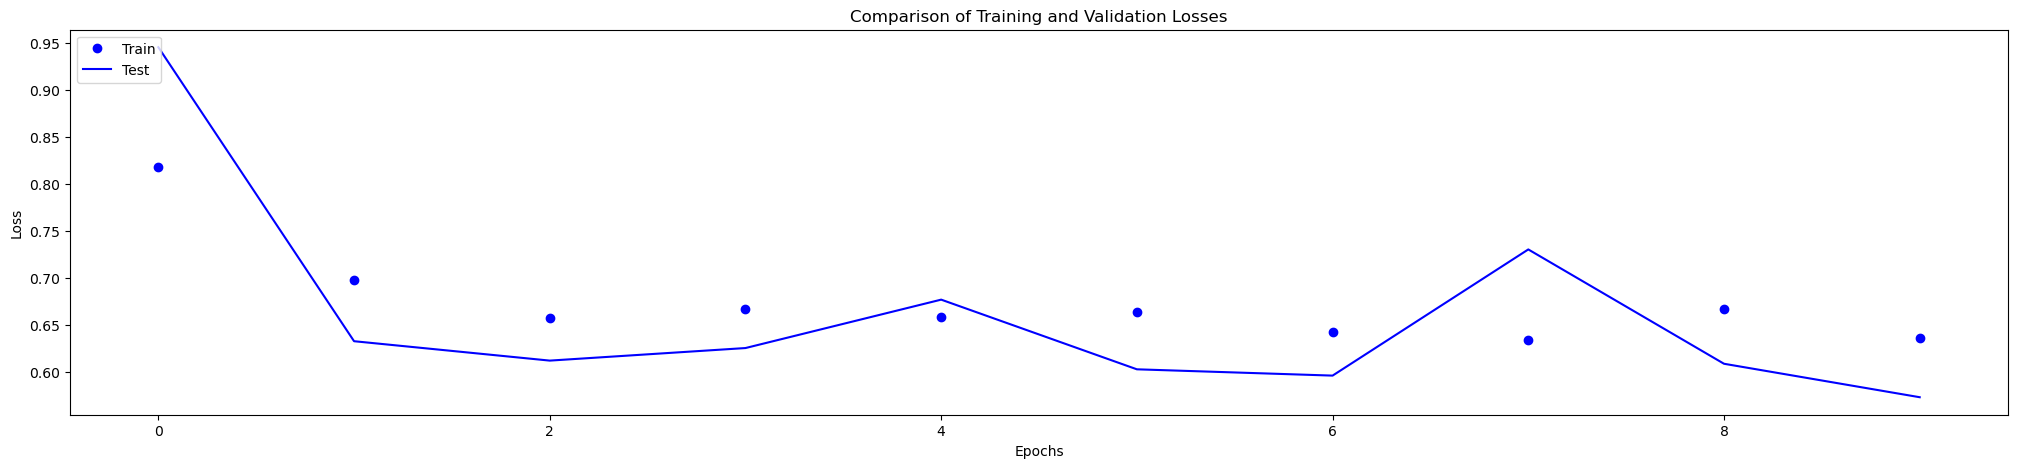

In [185]:
acc1 = history.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

# models_acc.append(acc1)
# models_val_acc.append(val_acc1)
# models_loss.append(loss1)
# models_val_loss.append(val_loss1)

PlotAccuracyComparison(acc1, val_acc1, lab = 'Model 1')
PlotLossComparison(loss1, val_loss1, lab = 'Model 1')

### Model 2

In [20]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))
model2.add(layers.Conv2D(512, (3, 3), activation='relu'))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 256)      0

In [22]:
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [23]:
history2 = model2.fit(
      train_generator,
      steps_per_epoch=25,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=7)

Epoch 1/15
25/25 [==============================] - 16s 256ms/step - loss: 0.6877 - accuracy: 0.5429 - precision_1: 0.5465 - recall_1: 0.5193 - val_loss: 0.6667 - val_accuracy: 0.6095 - val_precision_1: 0.5652 - val_recall_1: 0.9811
Epoch 2/15
25/25 [==============================] - 5s 211ms/step - loss: 0.6749 - accuracy: 0.5706 - precision_1: 0.5634 - recall_1: 0.6593 - val_loss: 0.6270 - val_accuracy: 0.7524 - val_precision_1: 0.7755 - val_recall_1: 0.7170
Epoch 3/15
25/25 [==============================] - 5s 206ms/step - loss: 0.6430 - accuracy: 0.6205 - precision_1: 0.6178 - recall_1: 0.6484 - val_loss: 0.6075 - val_accuracy: 0.6000 - val_precision_1: 0.5579 - val_recall_1: 1.0000
Epoch 4/15
25/25 [==============================] - 5s 206ms/step - loss: 0.6250 - accuracy: 0.6620 - precision_1: 0.6465 - recall_1: 0.7111 - val_loss: 0.5443 - val_accuracy: 0.7714 - val_precision_1: 0.8085 - val_recall_1: 0.7170
Epoch 5/15
25/25 [==============================] - 5s 209ms/step - los

In [24]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

<Figure size 640x480 with 0 Axes>

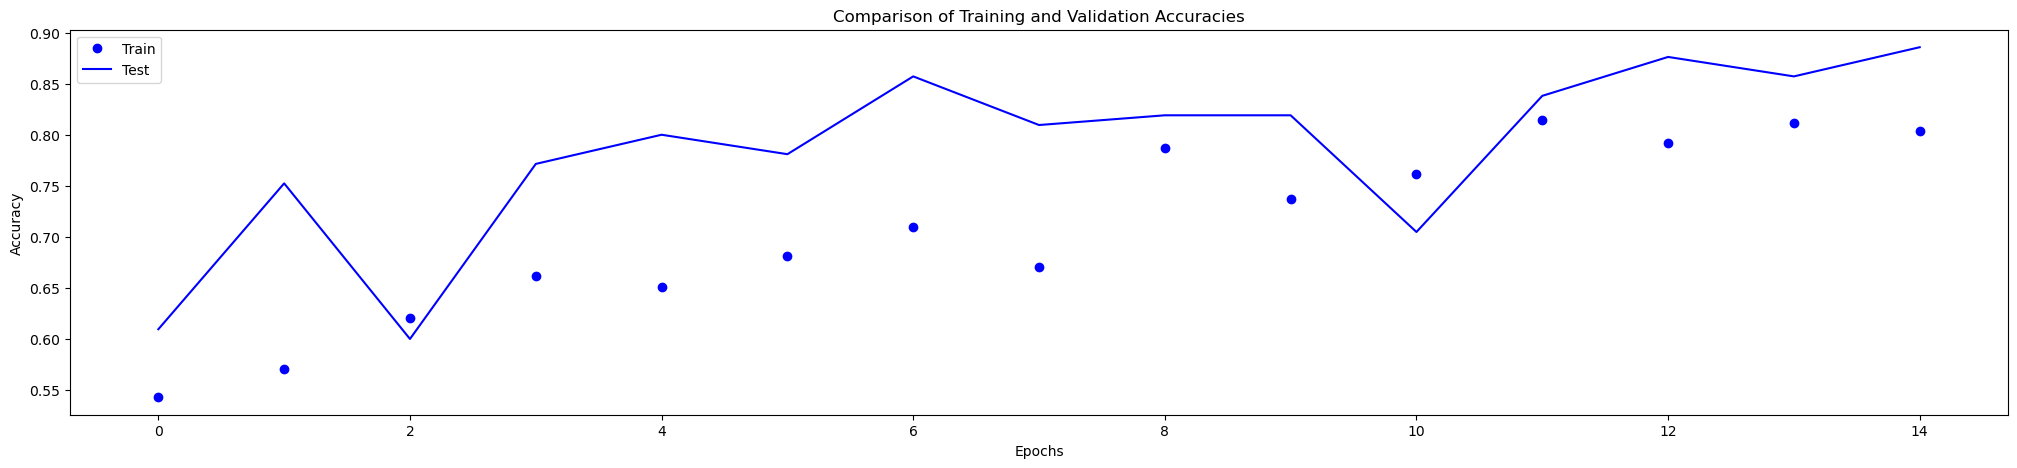

<Figure size 640x480 with 0 Axes>

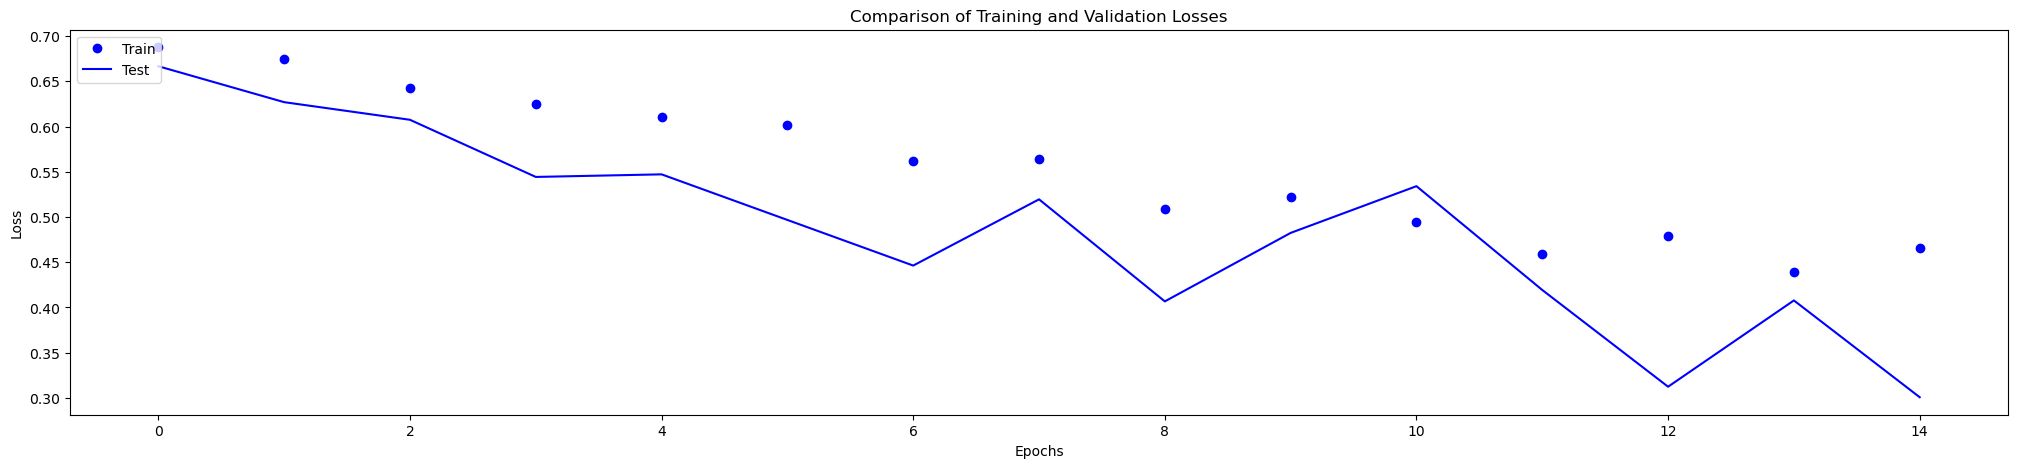

In [28]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

precision2 = np.array(history2.history['precision_1'])
val_precision2 = np.array(history2.history['val_precision_1'])
recall2 = np.array(history2.history['recall_1'])
val_recall2 = np.array(history2.history['val_recall_1'])
# models_acc.append(acc1)
# models_val_acc.append(val_acc1)
# models_loss.append(loss1)
# models_val_loss.append(val_loss1)

PlotAccuracyComparison(acc2, val_acc2, lab = 'Model 1')
PlotLossComparison(loss2, val_loss2, lab = 'Model 1')

In [29]:
def F1(precission, recall):
    return 2 * (precission * recall) / (precission + recall)

Text(0.5, 1.0, 'F1 vs Validation F1')

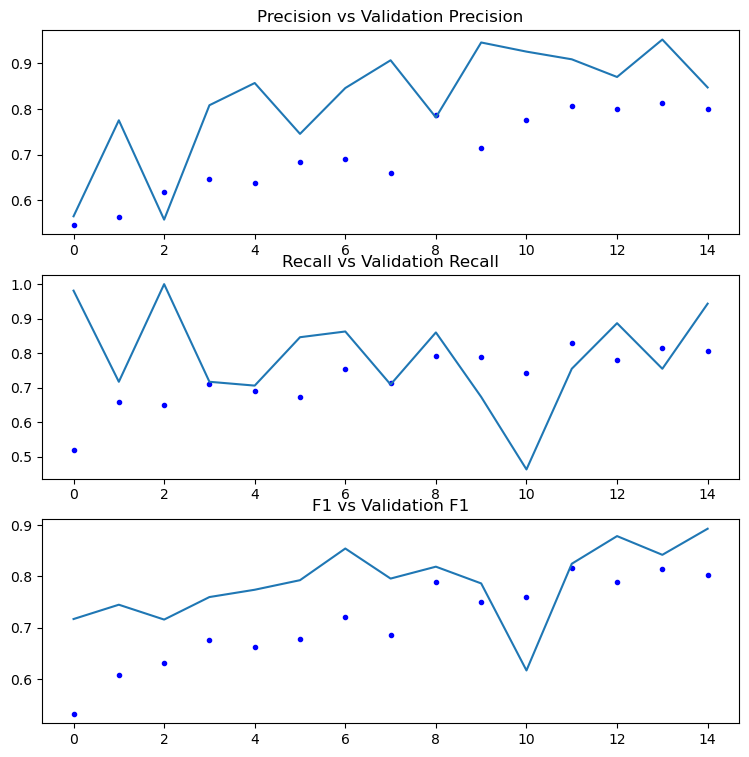

In [30]:
# F1-Score
f1 =  F1(precision2, recall2) 
f1_val = F1(val_precision2, val_recall2)

fig, axs = plt.subplots(3, figsize=(9,9))

axs[0].plot(precision2, 'b.')
axs[0].plot(val_precision2)
axs[0].set_title('Precision vs Validation Precision')
axs[1].plot(recall2, 'b.')
axs[1].plot(val_recall2)
axs[1].set_title('Recall vs Validation Recall')
axs[2].plot(f1, 'b.')
axs[2].plot(f1_val)
axs[2].set_title('F1 vs Validation F1')

In [31]:
model2.evaluate(test_generator)

7/7 [==============================] - 1s 139ms/step - loss: 0.3598 - accuracy: 0.8200 - precision_1: 0.7857 - recall_1: 0.8800


[0.3598276972770691,
 0.8199999928474426,
 0.7857142686843872,
 0.8799999952316284]

#### Accuracy 82% on test set

Continue testing
<!-- # ConvNet (CNN) visualisations -->

In [246]:
import numpy as np
from tensorflow.keras.preprocessing import image

def prepare_img(img_path):
    img = image.load_img(img_path)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    print(img_tensor.shape)   
    return img_tensor

In [248]:
img_path_normal = base_dir + 'test/normal/3354_left.jpg'
img_path_cataract = base_dir + 'test/cataract/2233_right.jpg'

img_tensor_normal = prepare_img(img_path_normal)
img_tensor_cataract = prepare_img(img_path_cataract)

(1, 256, 256, 3)
(1, 256, 256, 3)


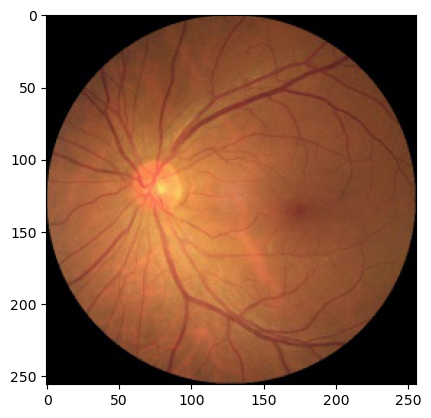

In [250]:
plt.imshow(img_tensor_normal[0])

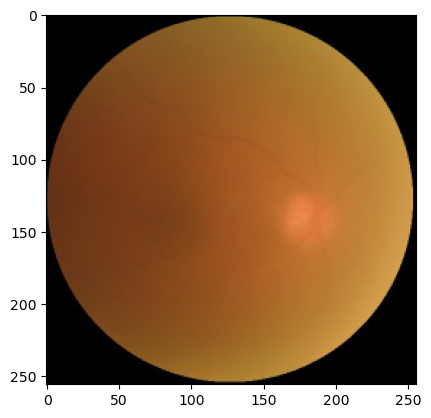

In [251]:
plt.imshow(img_tensor_cataract[0])

### Oversampling - augment the `cataract` class data

Prepare augmented data

In [265]:
# The path to store trained models
models_dir = r'./models/' 
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where is original dataset
original_dataset_dir = r'./data/preprocessed_images/'

# The directory where we will store our smaller dataset
base_dir = r'./dataset256_binary_augmented/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

split_dir = base_dir + r'split256/'
if not os.path.exists(split_dir):
    os.mkdir(split_dir)

# Prepare directories for the class separation
normal_dir = os.path.join(split_dir, r'normal256')
if not os.path.exists(normal_dir):
    os.mkdir(normal_dir)

cataract_dir = os.path.join(split_dir, r'cataract256')
if not os.path.exists(cataract_dir):
    os.mkdir(cataract_dir)

In [267]:
class DataClass():
    def __init__(self, _name: str, _filenames: [str], _target: [int], _abbreviation: str, _directory: str):
        self.name = _name
        self.filenames = _filenames
        self.target = _target
        self.abbreviation  = _abbreviation
        self.directory = _directory
        
    def __str__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"
    
    def __repr__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"

# THAT'S WRONG! THIS LABEL IS ATTACHED TO EACH PATIENT NOT TO EACH EYE!
# UPDATE: it's correct, labels are correctly assigned even though each label columns are 
# attached to each patient
normal_filenames = df_eye[df_eye.labels == "['N']"].filename.values
cataract_filenames = df_eye[df_eye.labels == "['C']"].filename.values

normal_class = DataClass('normal', normal_filenames, [1, 0, 0, 0, 0, 0, 0, 0], 'N', normal_dir)
cataract_class = DataClass('cataract', cataract_filenames, [0, 0, 0, 1, 0, 0, 0, 0], 'C', cataract_dir)

data_classes = [
    normal_class, 
    cataract_class, 
]

### Copy images

In [270]:
# from random import sample

# num_of_imgs = len(cataract_class.filenames)

# Copy files to each class dir
for data_class in data_classes:
    class_dir = data_class.directory
    if os.path.exists(class_dir) and not os.path.isfile(class_dir):
        # Check if the directory is empty
        if not os.listdir(class_dir):
            # copy files
                #  limit images
            # data_class.filenames = sample([*data_class.filenames],num_of_imgs)
            for fname in data_class.filenames:
                src = os.path.join(original_dataset_dir, fname)
                img = cv2.imread(src)
                # resize img to 256x256
                resized_img = cv2.resize(img, (256, 256))
                # save scaled img
                dst = data_class.directory + "/" + fname
                cv2.imwrite(dst, resized_img)
                # shutil.copyfile(src, dst)
    # validate if number of each class in dataframe and destination directory is the same
    # assert(num_of_imgs == len(os.listdir(class_dir)))
    assert(len(data_class.filenames) == len(os.listdir(class_dir)))    

# Split data

In [296]:
train_dir = r'./dataset256_binary_augmented/train/'
validation_dir = r'./dataset256_binary_augmented/validation/'
test_dir = r'./dataset256_binary_augmented/test/'

img_rows = 256
img_cols = 256

### Update classnames with augmented ones

In [312]:
cataract_class.filenames = os.listdir('./dataset256_binary_augmented_v2/split256/cataract256')
normal_class.filenames = os.listdir('./dataset256_binary_augmented_v2/split256/normal256')

In [313]:
from sklearn.model_selection import train_test_split

# prepare data sets
def prepare_data(data_class: DataClass, train_size: float, validation_test_ratio:float, img_count=-1):
    # validation_test_ratio -> how much of `data - train_data` goes to validation
    # 
    # for instance, we've given: train_size, validation_test_ratio
    # then
    # train_size = data * train_size
    # validation_size = ( 1 - train_size) * validation_test_ratio
    # test_size = ( 1 - train_size) * (1 - validation_test_ratio)
    # ---
    
    # check if directories are created
    class_train_dir = os.path.join(train_dir, data_class.name)
    if not os.path.exists(class_train_dir):
        os.makedirs(class_train_dir)
    print(class_train_dir)
    
    class_validation_dir = os.path.join(validation_dir, data_class.name)
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

    class_test_dir = os.path.join(test_dir, data_class.name)
    if not os.path.exists(class_test_dir):
        os.makedirs(class_test_dir)
    
    # split class filenames into three separate bins in line with split ratio
    if img_count == -1:
        class_filenames = data_class.filenames
    else:
        assert(img_count > 0 and img_count < data_class.filenames)
        class_filenames = data_class.filenames[:img_count]
    train_filenames, test_valid_filenames = train_test_split(class_filenames, test_size=1.0-train_size)
    # divide images into test and validation sets
    validation_filenames, test_filenames = train_test_split(test_valid_filenames, test_size=1-validation_test_ratio)
    
    for key, destination_dir, filenames in [('train', class_train_dir, train_filenames), ('test', class_test_dir, test_filenames), ('validation', class_validation_dir, validation_filenames)]:
        if os.path.exists(destination_dir) and not os.path.isfile(destination_dir):
            # Checking if the directory is empty or not
            if not os.listdir(destination_dir):
                # copy files
                for filename in filenames:
                    src = os.path.join(split_dir + f"{data_class.name}256/{filename}")
                    dst = os.path.join(destination_dir, filename)
                    shutil.copyfile(src, dst)
        # validate if number of each class in dataframe and destination directory is the same
        # assert(len(filenames) == len(os.listdir(destination_dir)))

In [314]:
for data_class in data_classes:
    prepare_data(data_class, train_size=0.7, validation_test_ratio=0.7)

./dataset256_binary_augmented_v2/train/normal
./dataset256_binary_augmented_v2/train/cataract


In [289]:
# with augmentation
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    class_mode='binary')

Found 2019 images belonging to 2 classes.
Found 261 images belonging to 2 classes.
Found 605 images belonging to 2 classes.


# Model 2 on augmented data

In [286]:
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [290]:
history2 = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=30)

Epoch 1/20
100/100 [==============================] - 28s 252ms/step - loss: 0.5895 - accuracy: 0.6848 - precision_6: 0.6850 - recall_8: 0.9737 - val_loss: 0.4913 - val_accuracy: 0.8033 - val_precision_6: 0.7970 - val_recall_8: 0.9449
Epoch 2/20
100/100 [==============================] - 21s 206ms/step - loss: 0.4456 - accuracy: 0.7939 - precision_6: 0.7983 - recall_8: 0.9223 - val_loss: 0.3232 - val_accuracy: 0.8533 - val_precision_6: 0.8475 - val_recall_8: 0.9497
Epoch 3/20
100/100 [==============================] - 21s 206ms/step - loss: 0.3402 - accuracy: 0.8464 - precision_6: 0.8726 - recall_8: 0.8996 - val_loss: 0.2335 - val_accuracy: 0.9133 - val_precision_6: 0.9203 - val_recall_8: 0.9525
Epoch 4/20
100/100 [==============================] - 21s 206ms/step - loss: 0.2658 - accuracy: 0.8884 - precision_6: 0.9164 - recall_8: 0.9157 - val_loss: 0.2134 - val_accuracy: 0.9117 - val_precision_6: 0.9240 - val_recall_8: 0.9449
Epoch 5/20
100/100 [==============================] - 21s 20

In [215]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'precision_5', 'recall_7', 'val_loss', 'val_accuracy', 'val_precision_5', 'val_recall_7'])

<Figure size 640x480 with 0 Axes>

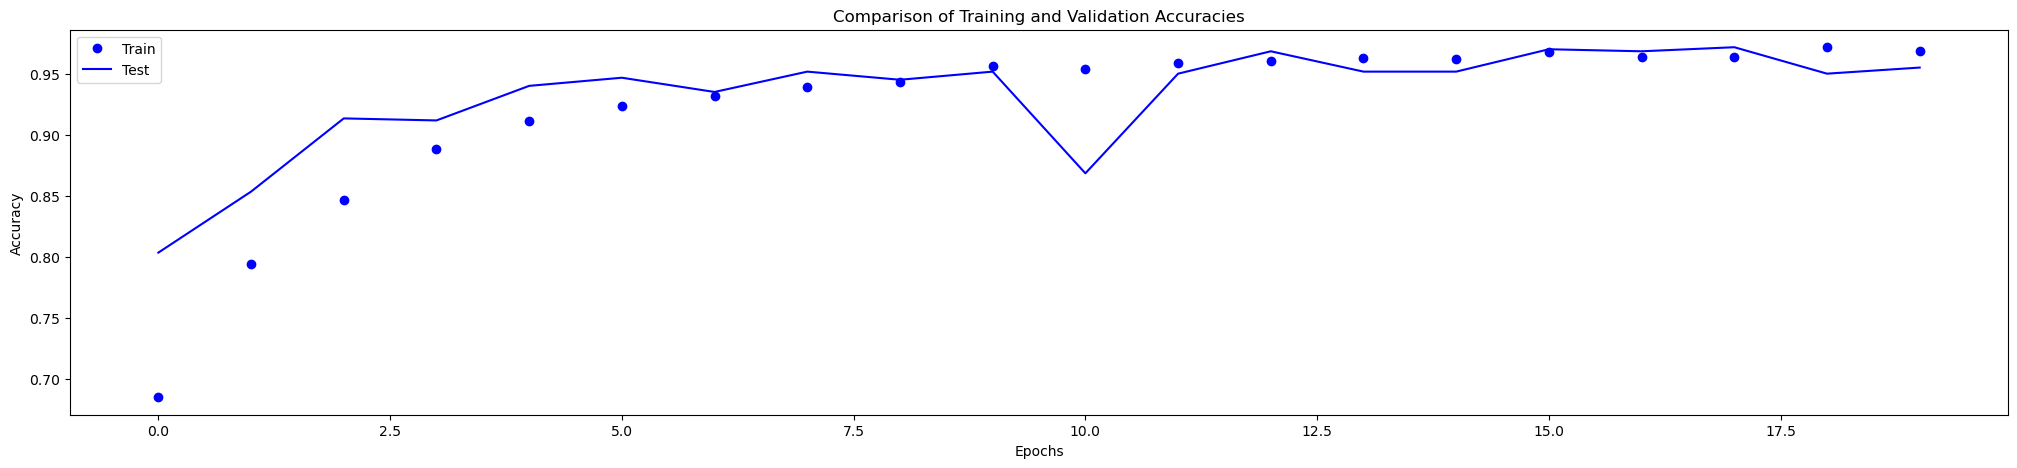

<Figure size 640x480 with 0 Axes>

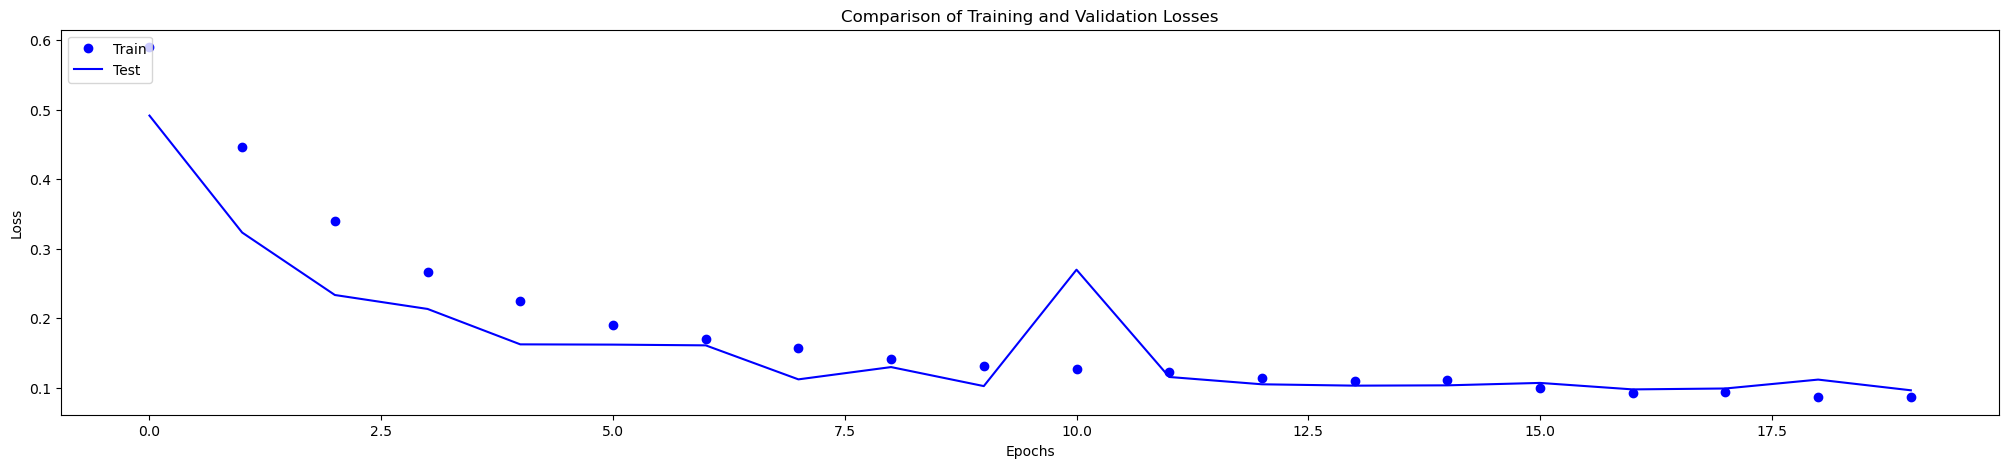

In [292]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

precision2 = np.array(history2.history['precision_6'])
val_precision2 = np.array(history2.history['val_precision_6'])
recall2 = np.array(history2.history['recall_8'])
val_recall2 = np.array(history2.history['val_recall_8'])
# models_acc.append(acc1)
# models_val_acc.append(val_acc1)
# models_loss.append(loss1)
# models_val_loss.append(val_loss1)

PlotAccuracyComparison(acc2, val_acc2, lab = 'Model 1')
PlotLossComparison(loss2, val_loss2, lab = 'Model 1')

In [293]:
def F1(precission, recall):
    return 2 * (precission * recall) / (precission + recall)

Text(0.5, 1.0, 'F1 vs Validation F1')

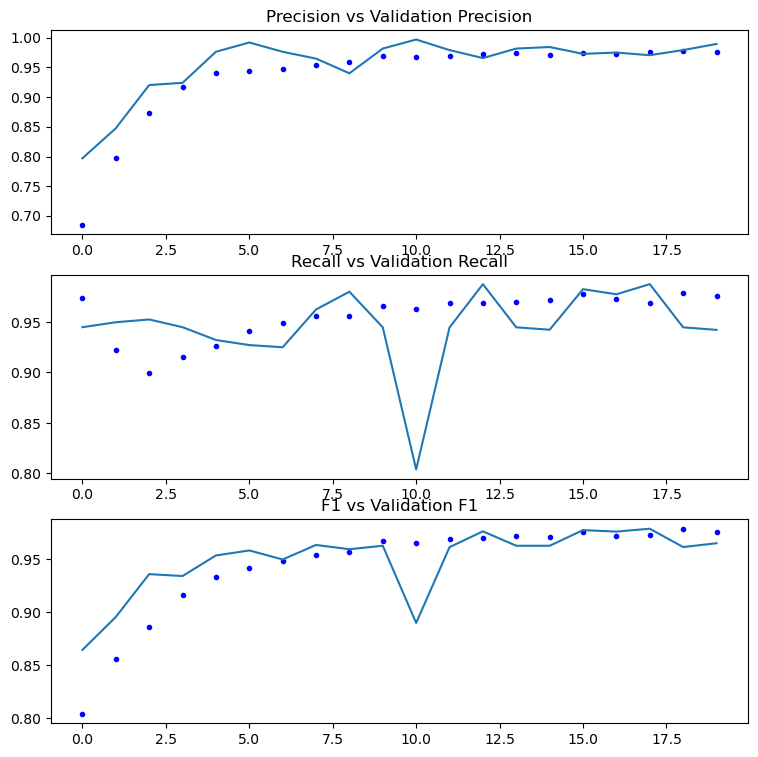

In [294]:
# F1-Score
f1 =  F1(precision2, recall2) 
f1_val = F1(val_precision2, val_recall2)

fig, axs = plt.subplots(3, figsize=(9,9))

axs[0].plot(precision2, 'b.')
axs[0].plot(val_precision2)
axs[0].set_title('Precision vs Validation Precision')
axs[1].plot(recall2, 'b.')
axs[1].plot(val_recall2)
axs[1].set_title('Recall vs Validation Recall')
axs[2].plot(f1, 'b.')
axs[2].plot(f1_val)
axs[2].set_title('F1 vs Validation F1')

In [295]:
model2.evaluate(test_generator)

14/14 [==============================] - 2s 119ms/step - loss: 0.1733 - accuracy: 0.9579 - precision_6: 0.9821 - recall_8: 0.9538


[0.1732822209596634,
 0.9578543901443481,
 0.9821428656578064,
 0.9537572264671326]

Wyniki otrzymane po wykonaniu augmentacji na zbiorze `cataract` są mocno podejrzane. Z 269 obrazów `cataract` powstało po augmentacji 700 kolejnych, biorąc pod uwagę fakt, że split na zbiory `validation`, `test` oraz `train` nastąpił po augmentacji obrazy bardzo podobne do siebie (kwestia przybliżenia lub delikatnej rotacji) mogły trafić zarówno do zbioru uczącego, walidacyjnego i testowego przez co model nie miał problemu z ich rozpoznaniem.

## Augment only `cataract` class images in train set  

In [302]:
train_dir = r'./dataset256_binary_augmented_v2/train/'
validation_dir = r'./dataset256_binary_augmented_v2/validation/'
test_dir = r'./dataset256_binary_augmented_v2/test/'

img_rows = 256
img_cols = 256

In [317]:
# with augmentation
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    class_mode='binary')

Found 1529 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 458 images belonging to 2 classes.


# without augmentation 

In [324]:
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])

In [325]:
history2 = model2.fit(
      train_generator,
      steps_per_epoch=75,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=22)

Epoch 1/20
75/75 [==============================] - 17s 207ms/step - loss: 0.3755 - precision_11: 0.8790 - recall_13: 0.9908 - acc: 0.8724 - val_loss: 0.3688 - val_precision_11: 0.8795 - val_recall_13: 1.0000 - val_acc: 0.8795
Epoch 2/20
75/75 [==============================] - 15s 204ms/step - loss: 0.3457 - precision_11: 0.8771 - recall_13: 1.0000 - acc: 0.8771 - val_loss: 0.3130 - val_precision_11: 0.8750 - val_recall_13: 1.0000 - val_acc: 0.8750
Epoch 3/20
75/75 [==============================] - 15s 204ms/step - loss: 0.3288 - precision_11: 0.8774 - recall_13: 0.9992 - acc: 0.8771 - val_loss: 0.2834 - val_precision_11: 0.8773 - val_recall_13: 1.0000 - val_acc: 0.8773
Epoch 4/20
75/75 [==============================] - 15s 204ms/step - loss: 0.3028 - precision_11: 0.8832 - recall_13: 0.9977 - acc: 0.8825 - val_loss: 0.3094 - val_precision_11: 0.9370 - val_recall_13: 0.9612 - val_acc: 0.9091
Epoch 5/20
75/75 [==============================] - 15s 204ms/step - loss: 0.2479 - precisio

In [327]:
history2.history.keys()

dict_keys(['loss', 'precision_11', 'recall_13', 'acc', 'val_loss', 'val_precision_11', 'val_recall_13', 'val_acc'])

<Figure size 640x480 with 0 Axes>

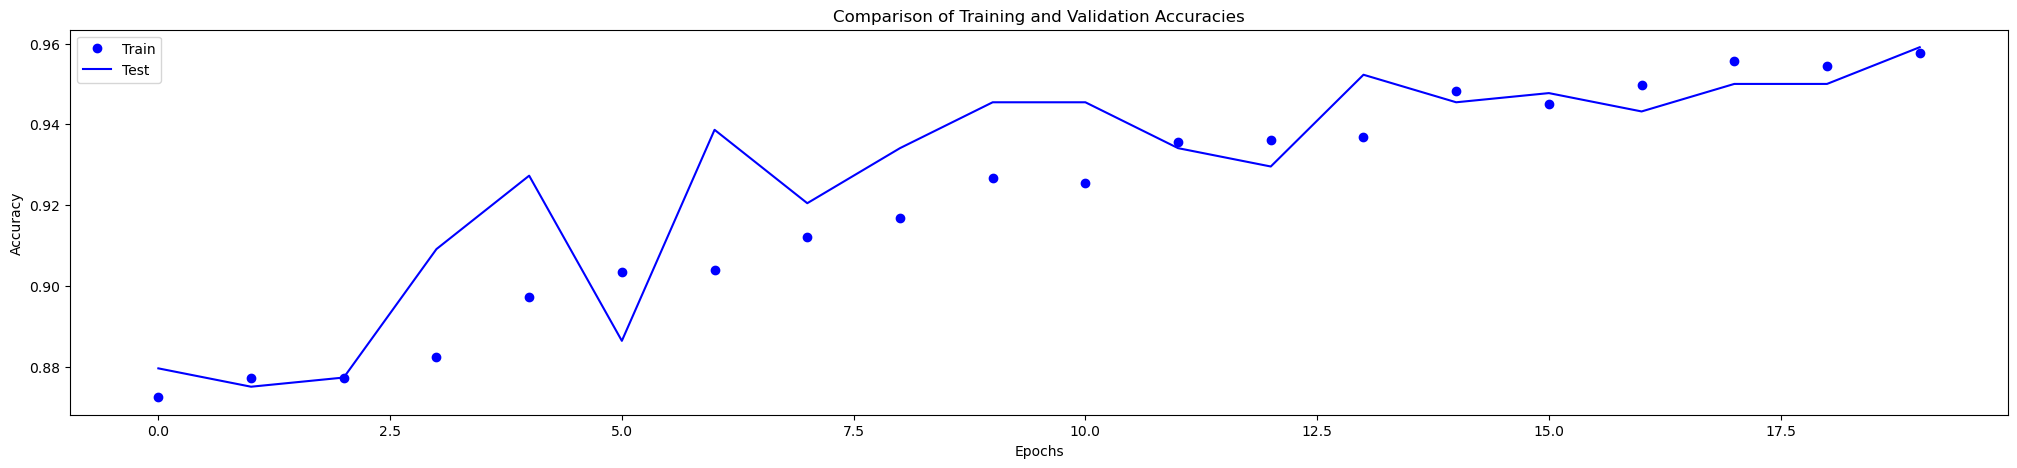

<Figure size 640x480 with 0 Axes>

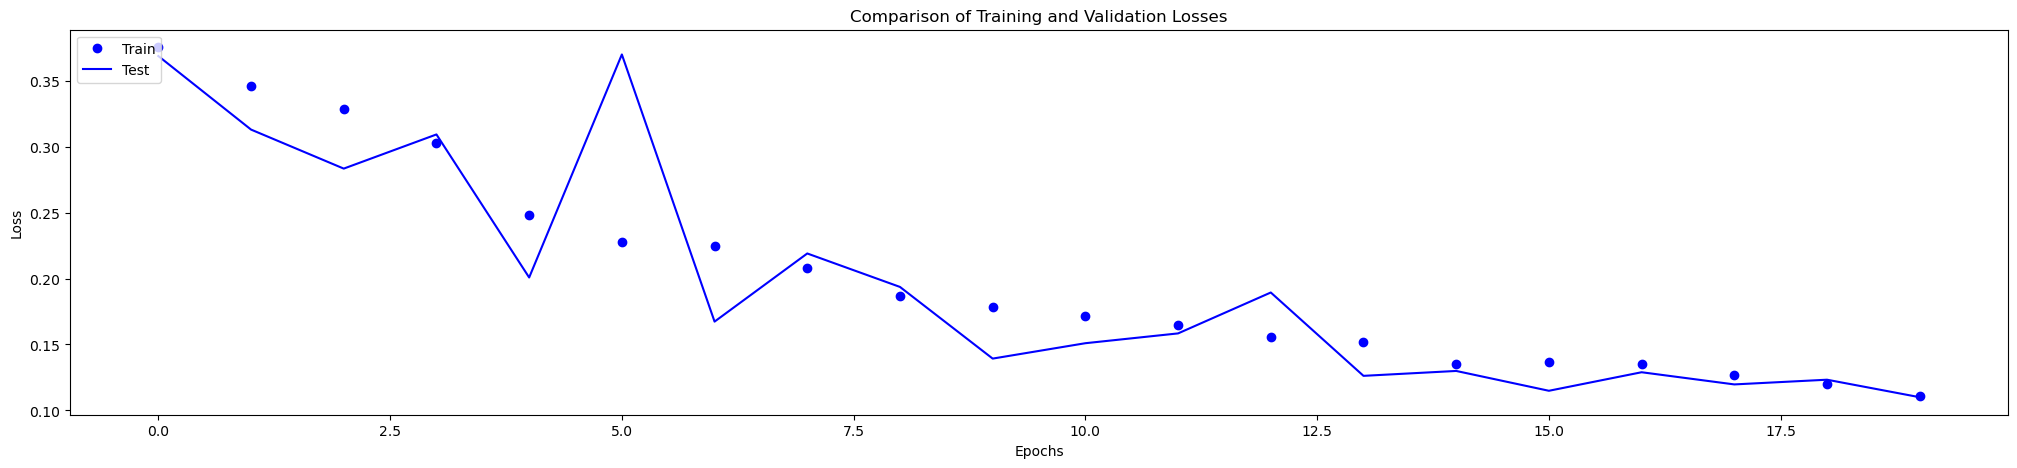

In [331]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

precision2 = np.array(history2.history['precision_11'])
val_precision2 = np.array(history2.history['val_precision_11'])
recall2 = np.array(history2.history['recall_13'])
val_recall2 = np.array(history2.history['val_recall_13'])
# models_acc.append(acc1)
# models_val_acc.append(val_acc1)
# models_loss.append(loss1)
# models_val_loss.append(val_loss1)

PlotAccuracyComparison(acc2, val_acc2, lab = 'Model 2')
PlotLossComparison(loss2, val_loss2, lab = 'Model 2')

In [332]:
def F1(precission, recall):
    return 2 * (precission * recall) / (precission + recall)

Text(0.5, 1.0, 'F1 vs Validation F1')

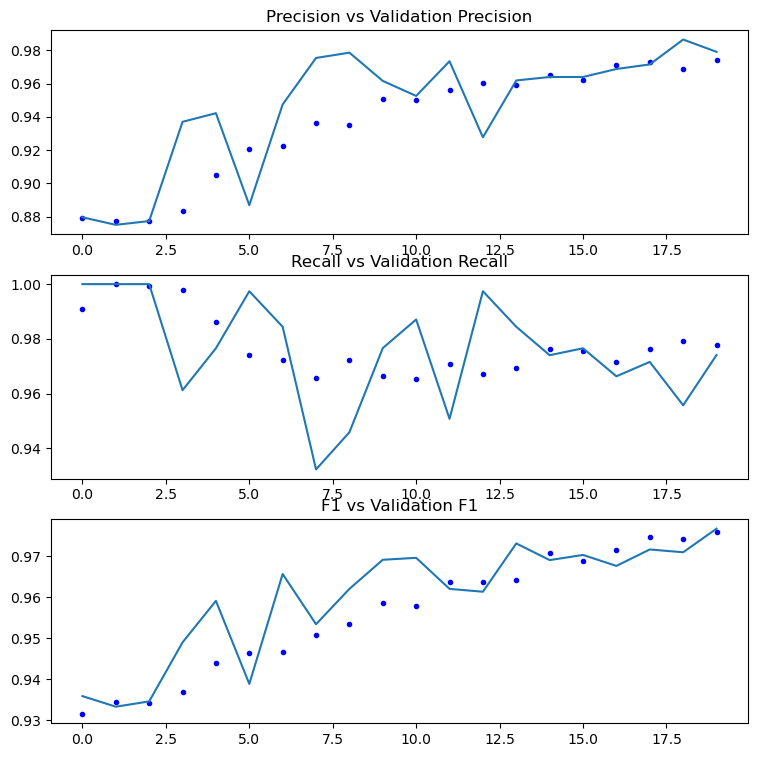

In [333]:
# F1-Score
f1 =  F1(precision2, recall2) 
f1_val = F1(val_precision2, val_recall2)

fig, axs = plt.subplots(3, figsize=(9,9))

axs[0].plot(precision2, 'b.')
axs[0].plot(val_precision2)
axs[0].set_title('Precision vs Validation Precision')
axs[1].plot(recall2, 'b.')
axs[1].plot(val_recall2)
axs[1].set_title('Recall vs Validation Recall')
axs[2].plot(f1, 'b.')
axs[2].plot(f1_val)
axs[2].set_title('F1 vs Validation F1')

In [334]:
model2.evaluate(test_generator)

10/10 [==============================] - 2s 174ms/step - loss: 0.1210 - precision_11: 0.9709 - recall_13: 0.9653 - acc: 0.9444


[0.12095967680215836,
 0.9709302186965942,
 0.9653179049491882,
 0.9444444179534912]

# with augmentation
see `06_data_augmentation` notebook

### Pie chart 

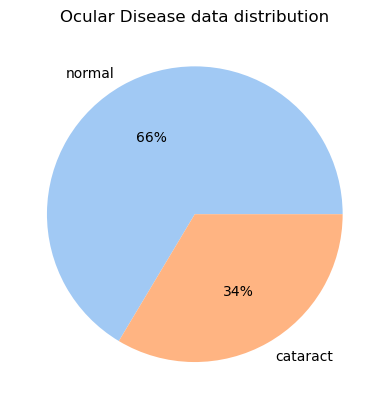

In [282]:
colors = sns.color_palette('pastel')[:2]

plt.pie([1916,969], labels = ['normal', 'cataract'], colors = colors, autopct='%.0f%%')
plt.title('Ocular Disease data distribution')
plt.show()

In [351]:
# with augmentation
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    class_mode='binary')

Found 2093 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 458 images belonging to 2 classes.


In [342]:
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])

In [343]:
history2 = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=22)

Epoch 1/20
100/100 [==============================] - 23s 223ms/step - loss: 0.5945 - precision_13: 0.6778 - recall_15: 0.9477 - acc: 0.6769 - val_loss: 0.5394 - val_precision_13: 0.9604 - val_recall_15: 0.7539 - val_acc: 0.7568
Epoch 2/20
100/100 [==============================] - 20s 201ms/step - loss: 0.4437 - precision_13: 0.8088 - recall_15: 0.8939 - acc: 0.7958 - val_loss: 0.2908 - val_precision_13: 0.9492 - val_recall_15: 0.9149 - val_acc: 0.8818
Epoch 3/20
100/100 [==============================] - 20s 200ms/step - loss: 0.3219 - precision_13: 0.8864 - recall_15: 0.9109 - acc: 0.8690 - val_loss: 0.2130 - val_precision_13: 0.9554 - val_recall_15: 0.9455 - val_acc: 0.9136
Epoch 4/20
100/100 [==============================] - 20s 201ms/step - loss: 0.2636 - precision_13: 0.9202 - recall_15: 0.9166 - acc: 0.8951 - val_loss: 0.2205 - val_precision_13: 0.9625 - val_recall_15: 0.9325 - val_acc: 0.9091
Epoch 5/20
100/100 [==============================] - 20s 200ms/step - loss: 0.2189 

In [346]:
history2.history.keys()

dict_keys(['loss', 'precision_13', 'recall_15', 'acc', 'val_loss', 'val_precision_13', 'val_recall_15', 'val_acc'])

<Figure size 640x480 with 0 Axes>

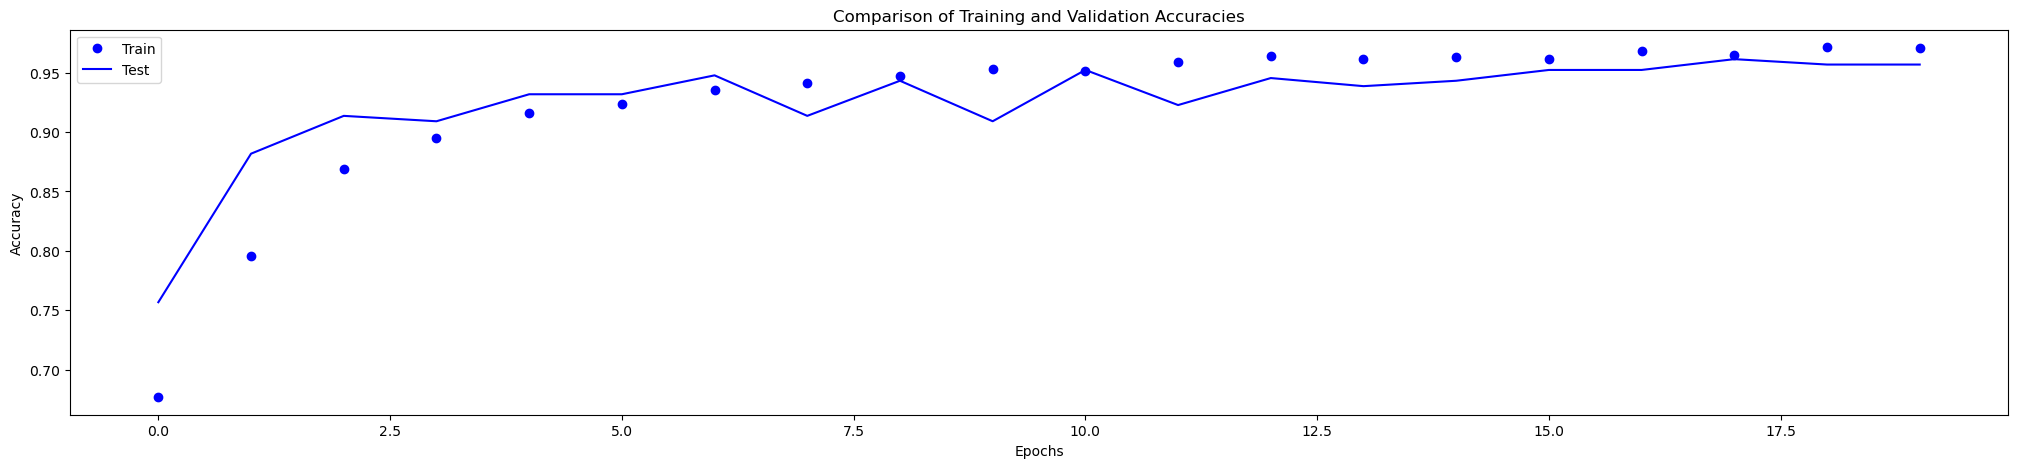

<Figure size 640x480 with 0 Axes>

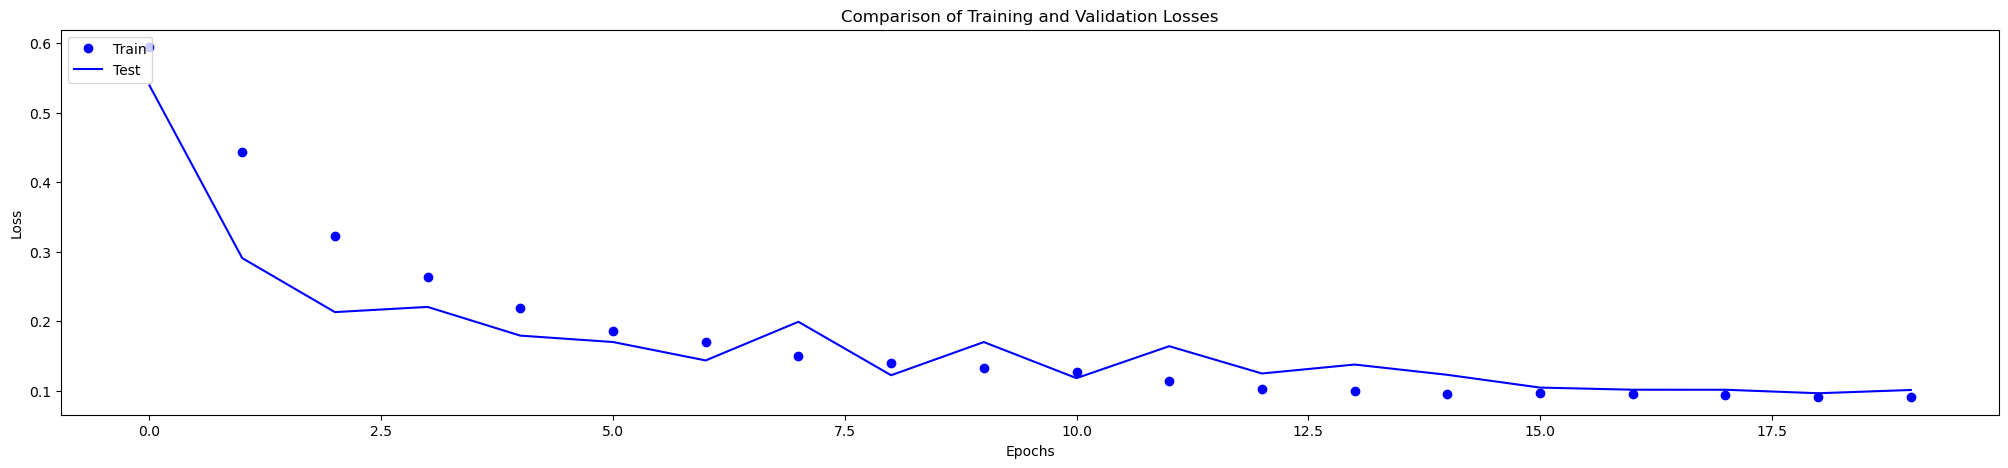

In [347]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

precision2 = np.array(history2.history['precision_13'])
val_precision2 = np.array(history2.history['val_precision_13'])
recall2 = np.array(history2.history['recall_15'])
val_recall2 = np.array(history2.history['val_recall_15'])
# models_acc.append(acc1)
# models_val_acc.append(val_acc1)
# models_loss.append(loss1)
# models_val_loss.append(val_loss1)

PlotAccuracyComparison(acc2, val_acc2, lab = 'Model 2')
PlotLossComparison(loss2, val_loss2, lab = 'Model 2')

Text(0.5, 1.0, 'F1 vs Validation F1')

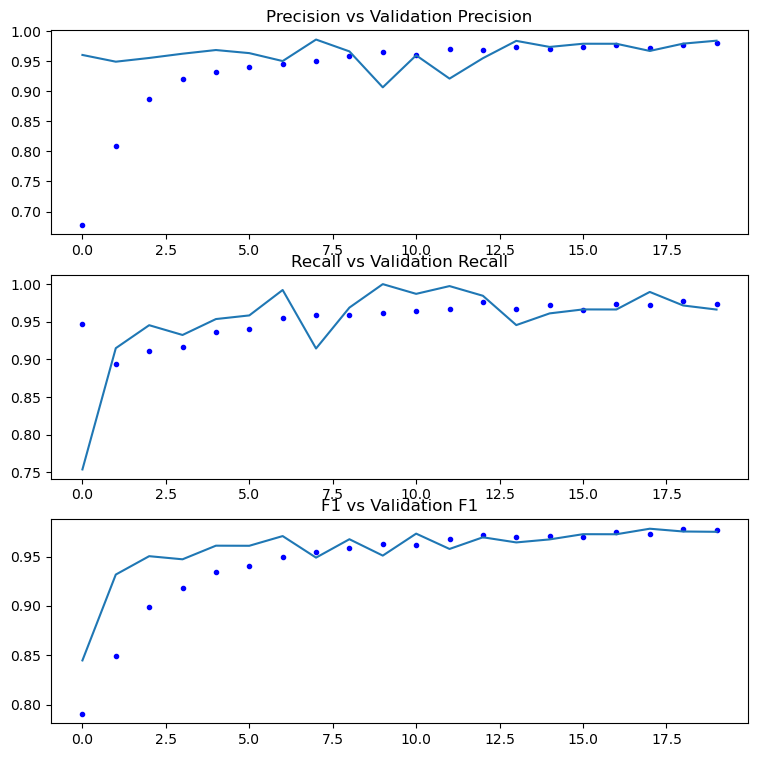

In [348]:
# F1-Score
f1 =  F1(precision2, recall2) 
f1_val = F1(val_precision2, val_recall2)

fig, axs = plt.subplots(3, figsize=(9,9))

axs[0].plot(precision2, 'b.')
axs[0].plot(val_precision2)
axs[0].set_title('Precision vs Validation Precision')
axs[1].plot(recall2, 'b.')
axs[1].plot(val_recall2)
axs[1].set_title('Recall vs Validation Recall')
axs[2].plot(f1, 'b.')
axs[2].plot(f1_val)
axs[2].set_title('F1 vs Validation F1')

In [349]:
model2.evaluate(test_generator)

10/10 [==============================] - 1s 62ms/step - loss: 0.1256 - precision_13: 0.9767 - recall_15: 0.9711 - acc: 0.9545


[0.12556301057338715,
 0.9767441749572754,
 0.9710982441902161,
 0.9545454382896423]

### Without augmentation (269 images `cataract`, 2000 `normal`): 

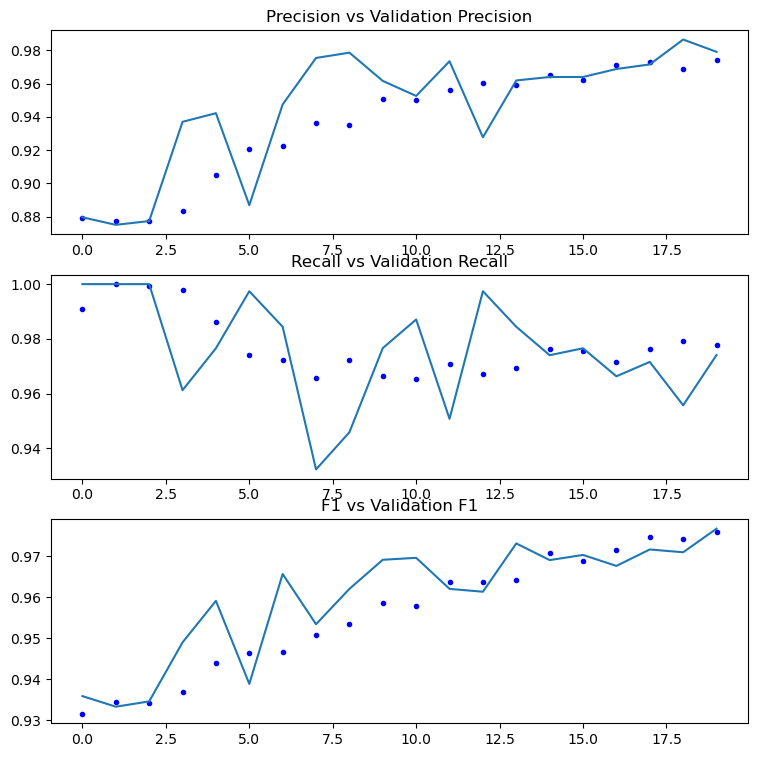

### With augmentation (800 imgages `cataract`, 2000 `normal`): 
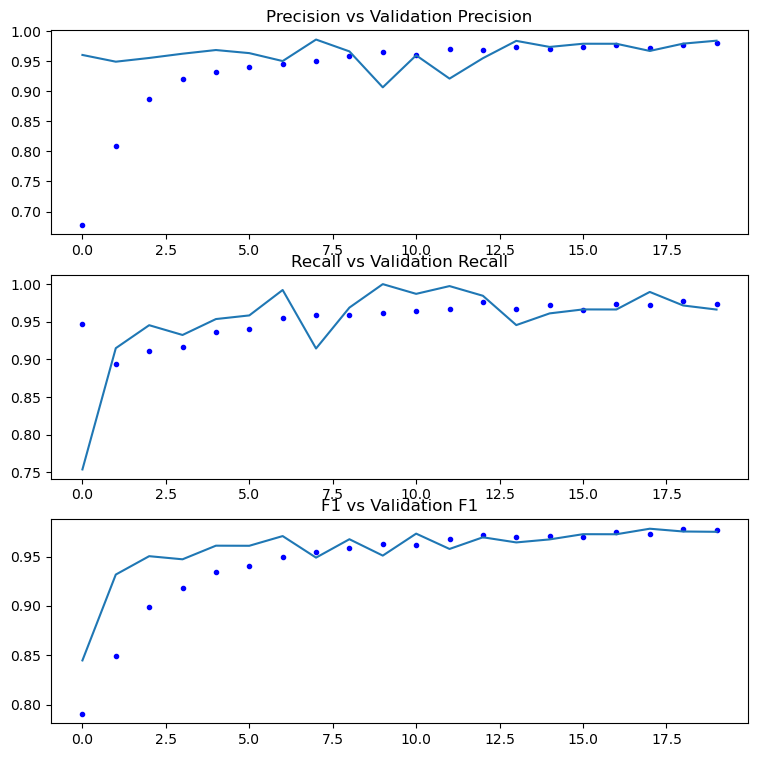

Binary classification works fine with the created model. Classes cataract and normal are easily distinguishable.